In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

import uproot
import pickle
import nue_booster

In [17]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open("root_files/mc_bnb.root")[fold][tree]
nue = uproot.open("root_files/new/nue.root")[fold][tree]
data = uproot.open("root_files/bnb.root")[fold][tree]
ext = uproot.open("root_files/ext.root")[fold][tree]
dirt = uproot.open("root_files/dirt.root")[fold][tree]
lee = uproot.open("root_files/new/nue.root")[fold][tree]

variables = nue_booster.variables.copy()
variables.remove("is_signal")
variables.remove("train_weight")
variables.append("category")
variables.append("selected")

mc = mc.pandas.df(variables, flatten=False)
nue = nue.pandas.df(variables + ["true_e_visible"], flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables, flatten=False)
lee = lee.pandas.df(variables + ["leeweight", "true_e_visible"], flatten=False)

lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

lee["reco_e"] = (lee["shr_energy_tot"] + 0.02) / 0.8 + lee["trk_energy_tot"]
data["reco_e"] = (data["shr_energy_tot"] + 0.02) / 0.8 + data["trk_energy_tot"]
nue["reco_e"] = (nue["shr_energy_tot"] + 0.02) / 0.8 + nue["trk_energy_tot"]
mc["reco_e"] = (mc["shr_energy_tot"] + 0.02) / 0.8 + mc["trk_energy_tot"]
dirt["reco_e"] = (dirt["shr_energy_tot"] + 0.02) / 0.8 + dirt["trk_energy_tot"]
ext["reco_e"] = (ext["shr_energy_tot"] + 0.02) / 0.8 + ext["trk_energy_tot"]


In [18]:

lee_bins = [0, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8]
lee_scaling = [
    6.3744101, 6.3744101, 5.6455402, 3.7305500, 1.5091400, 1.0742800, 0.7540929,
    0.4763070, 0.1523270
]

mc = mc.query("selected==1")
nue = nue.query("selected==1")
ext = ext.query("selected==1")

nue["train_weight"] = 0
mc["train_weight"] = 0
ext["train_weight"] = 0

for i, lee_bin in enumerate(lee_bins):
    if i==0:
        continue
    nue.loc[(nue['reco_e'] > lee_bins[i-1]) & (nue['reco_e'] < lee_bins[i]), 'train_weight'] = lee_scaling[i-1]
    mc.loc[(mc['reco_e'] > lee_bins[i-1]) & (mc['reco_e'] < lee_bins[i]), 'train_weight'] = lee_scaling[i-1]
    ext.loc[(ext['reco_e'] > lee_bins[i-1]) & (ext['reco_e'] < lee_bins[i]), 'train_weight'] = lee_scaling[i-1]


Training category==31...
XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Validating...
area under the precision-recall curve: 0.984617
precision score: 0.925319
recall score: 0.978876

Training category==2...
XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Validating...
area under the precision-recall curve: 0.972342
precision score: 0.905544
recall score: 0.931559

Training category==21...
XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Validating...
area under the precision-recall curve: 0.980528
precision score: 0.918236
recall score: 0.967892

Training category==4...
XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Validating...
area under the precision-recall curve: 0.988330
precision score: 0.935918
recall score: 0.968737

Training category==0...
XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Validating...
area under the precision-recall curv

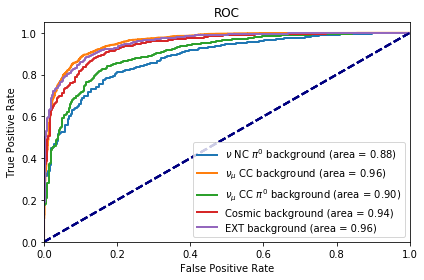

In [19]:
train_mc, toplot_mc = train_test_split(mc, test_size=0.5, random_state=1990)
train_ext, toplot_ext = train_test_split(ext, test_size=0.5, random_state=1990)
train_nue, toplot_nue = train_test_split(nue, test_size=0.5, random_state=1990)

fig, ax = plt.subplots(1,1)

for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
    
    preds = nue_booster.train_booster(nue, mc, ext, nue_booster.variables, ax, bkg_query)
    
    with open('pickles/booster_%s.pickle' % label, 'wb') as booster_file:
        pickle.dump(preds, booster_file)

    variables = nue_booster.variables.copy()
    variables.remove("is_signal")
    variables.remove("nu_e")
    variables.remove("train_weight")
        
    mc_prediction = preds.predict(
        xgb.DMatrix(mc[variables]),
        ntree_limit=preds.best_iteration + 1)
    nue_prediction = preds.predict(
        xgb.DMatrix(nue[variables]),
        ntree_limit=preds.best_iteration + 1)
    ext_prediction = preds.predict(
        xgb.DMatrix(ext[variables]),
        ntree_limit=preds.best_iteration + 1)
    
    
    mc["%s_score" % label] = mc_prediction
    nue["%s_score" % label] = nue_prediction
    ext["%s_score" % label] = ext_prediction


ax.set_ylim([0, 1.05])
ax.set_xlim([0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
ax.legend()
fig.tight_layout()

In [20]:
variables_bdts = [
    "is_signal", "nu_e", "train_weight", "ncpi0_score", "cc_score",
    "ccpi0_score", "cosmic_score", "ext_score"
]

Training ...
XGBoost params. ETA: 0.1, MAX_DEPTH: 10, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Validating...
area under the precision-recall curve: 0.909162
precision score: 0.922686
recall score: 0.682103



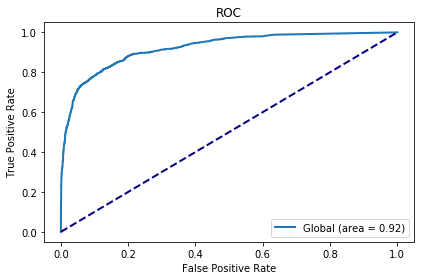

In [21]:
fig_global, ax_global = plt.subplots(1, 1)
preds = nue_booster.train_booster(nue, mc, ext, variables_bdts, ax_global)

ax_global.legend()
ax_global.set_xlabel('False Positive Rate')
ax_global.set_ylabel('True Positive Rate')
ax_global.set_title('ROC')
# ax_global.set_yscale("log")
fig_global.tight_layout()

In [23]:
with open('pickles/booster.pickle', 'wb') as booster_file:
    pickle.dump(preds, booster_file)